# 1 - Data tiling 🗺️ --> ⬜⬜⬜ ...
## From orthomosaic to tiles

Deep learning models are not able to digest RS data as a wall-to-wall product and therefore this represents the first step required for applying most deep learning models to geospatial data.

Depending on the application, deep learning architecture, and available computing resources one can modify the `tile_size`.

##### Inputs:
- `input_ortho_path`: path to drone orthomosaic (*.tif) 🗺️
- `tile_size_m`: length of the side of the tiles (m) 📏  
- `buffer_size_m`: overlap between adjatient tiles (m) 🗗

##### Output:
- a folder with tiled orthomosaic. This becomes the input to either train or predict with a YOLOv8 model.

### Define tiling and reference parameters

In [1]:
tile_size_m=10 # tile size in m
buffer_size_m=0 # tile buffer size_m (used to produce overlapping tiles)

In [2]:
# define path to your own google drive
my_drive_path="/content/drive/MyDrive"
path_data=my_drive_path+"/NOVA_course_deep_learning/data"

input_ortho_path=path_data+"/orthomosaics/test_data/ortho_hobol_042222_mavic_sun.tif" # this will be the drone mosaic


In [3]:
input_ortho_path

'/content/drive/MyDrive/NOVA_course_deep_learning/data/orthomosaics/test_data/ortho_hobol_042222_mavic_sun.tif'

### 1.1 Install and import required python libraries (not included in colab)

In [4]:
# install required libraries (if running in a local conda environment then other libraries might need to be installed)
!pip install geopandas
!pip install rasterio
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# general python packages
## general packages
import os, glob, shutil
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# geospatial packages
from osgeo import gdal, ogr, osr
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
import folium

# define path to where osgeo utils (gdal_retile.py) are stored
path_osgeo_utils= "/usr/local/lib/python3.10/dist-packages/osgeo_utils"

### 1.2 Mount google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# check what is in your google drive
!ls "/content/drive/My Drive"

 Aulas	    'ECA - Sensoriamento Remoto II'   Mestrado
 Classroom   Faculdade			      NOVA_course_deep_learning
 Dados_Doc   Fernanda			      NOVA_course_deep_learning_Curso
 DASOS	     Fernando
 Doutorado   _Latinos


### 1.3 Load data

#### Define paths to available orthomosaics

In [8]:
path_data=my_drive_path+"/NOVA_course_deep_learning/data/"
orthos = os.listdir(path_data+"/orthomosaics/test_data")

#all_flights_path="S:/Prosjekter/52106_SFI_SmartForest/annotated_datasets/SemanticSegmentation_windDamage/orthomosaics/allFlights_boundary.shp"
#all_flights = gpd.read_file(all_flights_path)

#all_flights.head()

In [9]:
orthos

['krakstad_202304_sun.tif',
 'ortho_hobol_042222_mavic_sun.tif',
 'braatan_40m_20230605_sun.tif',
 'galbyveien_20230504_sun.tif']

#### Load orthomosaic footprints (pre-create vector file)

In [10]:
# define directory to where the drone acquisition geojson is stored
dir_drone_acquisitions=path_data+"/map_data/drone_acquisitions.geojson"
dir_drone_acquisitions

'/content/drive/MyDrive/NOVA_course_deep_learning/data//map_data/drone_acquisitions.geojson'

In [11]:
footprints= gpd.read_file(dir_drone_acquisitions)

In [12]:
# Here you can get an overview of where the data are located
footprints.explore()

### 1.4 Tiling

For this example we will process a single orthomosaic. This process can be iterated through all of the available orthomosaics using a [for loop](https://wiki.python.org/moin/ForLoop).

In [13]:
# get orthomosaic name
ortho_name=os.path.splitext(os.path.basename(input_ortho_path)) [0]
ortho_name

'ortho_hobol_042222_mavic_sun'

Define and create an output directory to store the tiles

In [14]:
output_tiles_dir=path_data+"/tiles/"+str(tile_size_m)+"m_"+ortho_name
if not os.path.exists(output_tiles_dir):
    os.makedirs(output_tiles_dir)

output_tiles_dir

'/content/drive/MyDrive/NOVA_course_deep_learning/data//tiles/10m_ortho_hobol_042222_mavic_sun'

Get raster metadata that will be required later in the excercise (resolution, geographical ref. system, number of bands in raster)

In [15]:
output_tiles_dir

'/content/drive/MyDrive/NOVA_course_deep_learning/data//tiles/10m_ortho_hobol_042222_mavic_sun'

In [16]:
# Get pixel resolution (in meters) and tile size in pixels
src_ds = gdal.Open(input_ortho_path) # reads in the orthomosaic
_, xres, _, _, _, yres  = src_ds.GetGeoTransform() # get pixel size in meters
print("Ortho resolution: "+str(round(xres,4))+" m")

# Get EPSG code
proj = osr.SpatialReference(wkt=src_ds.GetProjection())
EPSG_code= proj.GetAttrValue('AUTHORITY',1)
print("EPSG code: "+str(EPSG_code))

# get number of bands
n_bands=src_ds.RasterCount
print("Number of bands: "+str(n_bands))

Ortho resolution: 0.0074 m
EPSG code: 25832
Number of bands: 4


# **Do the actual tiling** 😀
The tiling is done using [gdal_retile](https://gdal.org/programs/gdal_retile.html)

In [17]:
# Compute tile and buffer size in pixels
tile_size_px= round(tile_size_m/abs(xres)) # calculate the tile size in pixels
buffer_size_px= round(buffer_size_m/abs(xres)) # calculate the buffer size in pixels
print("The tile size in pixels is: "+str(tile_size_px))
print("The size of the overalp between tiles in pixels is: "+str(buffer_size_px))

The tile size in pixels is: 1358
The size of the overalp between tiles in pixels is: 0


In [18]:
# define name for output tile index shapefile
tileIndex_name=ortho_name+"_tile_index"

# Run gdal_retile.py using CLI (can take some minutes)
command_retile = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir + " " + input_ortho_path+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name + " -tileIndexField ID"
print(os.popen(command_retile).read())

0...10...20...30...40...50...60...70...80...90...100 - done.



### 1.5 selecting only tiles that are fully within the footprint polygon

Subset footprint polygons to select the one with filename equal to the one we are processing(krakstad_202304_sun)

In [19]:
footprint_ortho= footprints[footprints['filename']==ortho_name]
footprint_ortho_UU= footprint_ortho.geometry.unary_union

Keep only tiles that are fully within the ortho footprint. This is done to reduce storage space.



In [20]:
# Load tiles shapefile
tiles = gpd.read_file(output_tiles_dir+ "/"+ortho_name+"_tile_index.shp")
tiles= tiles.to_crs(EPSG_code)

# Select all tiles that are within the boundary polygon
tiles_in = tiles[tiles.geometry.within(footprint_ortho_UU)]

# Select all tiles that are not within the boundary polygon
tiles_out= tiles.loc[~tiles['ID'].isin(tiles_in['ID']) ]
print(str(len(tiles_out))+" tiles to be deleted")
print(str(len(tiles_in))+" tiles remaining")

194 tiles to be deleted
158 tiles remaining


In [21]:
# delete tiles that are not within the footprint
gtiffs_delete=[output_tiles_dir+ "/"+sub  for sub in tiles_out['ID']]
for f in gtiffs_delete:
   if os.path.exists(f):
     os.remove(f)

Plot footprint with all of the tiles and the ones that are fully within (green)

<Axes: >

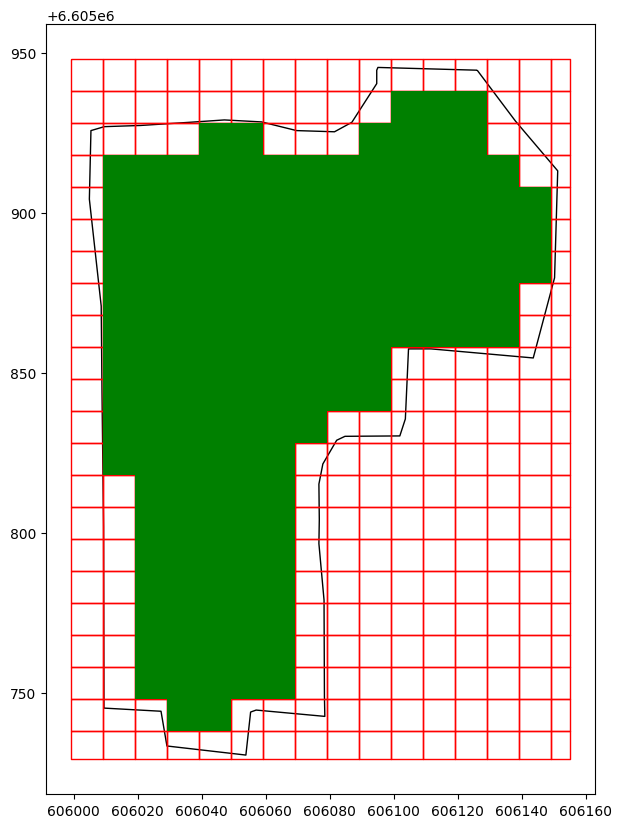

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
footprint_ortho.plot(ax=ax, edgecolor="black",facecolor="none")
tiles.plot(ax=ax, edgecolor="red",facecolor="none")
tiles_in.plot(ax=ax, color="green",facecolor="none")

## 🎉 Finsihed tiling orthomosaic!

In [23]:
print("Check in "+ output_tiles_dir+" for exported tiles")

Check in /content/drive/MyDrive/NOVA_course_deep_learning/data//tiles/10m_ortho_hobol_042222_mavic_sun for exported tiles


## Now start annotating data by following the [instructions in this document](https://docs.google.com/document/d/1kTsUY5bC1Jl-gvYWFoYRSFxgzf_0CLXfwEEYKkwpLGA/edit#)